<a href="https://colab.research.google.com/github/Rexosaury/COMSYS-Hackathon-5-2025/blob/main/Face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =======================
# 1. Mount Google Drive
# =======================
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ---------------------------
# Install & Import Libraries
# ---------------------------
!pip install insightface scikit-learn opencv-python-headless matplotlib tqdm
!pip install -U insightface onnxruntime
!pip install opencv-python-headless scikit-learn matplotlib tqdm

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

import insightface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 98.7 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp311-cp311-linux_x86_64.whl size=1060436 sha256=f33daef79f46ecd37eb4d1a3436d55000e7e9145f74478bbf9ebe0142bcf244a
  Stored in directory: /root/.cache/pip/wheels/27/d8/22/f52d858d16cd06e7b2e6aad34a1777dcfaf000be833bbf8146
Successfully built insightface
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.6 MB/s eta 0:00:00


In [ ]:
# ---------------------------
# Load ArcFace Model
# ---------------------------
model = insightface.app.FaceAnalysis(name='buffalo_l')
model.prepare(ctx_id=0)  # use CPU

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:05<00:00, 53009.08KB/s]
/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0


/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [ ]:
# ---------------------------
# IMAGE CLEANING FUNCTION
# ---------------------------
def clean_image(img):
    """
    Apply filtering to improve clarity of distorted images.
    Techniques:
      - Convert to grayscale
      - Histogram equalization (CLAHE)
      - Denoise
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    equalized = clahe.apply(gray)

    # Denoise
    denoised = cv2.fastNlMeansDenoising(equalized, h=10)

    # Convert back to 3-channels
    clean_img = cv2.merge([denoised, denoised, denoised])
    return clean_img


In [ ]:
# ---------------------------
# EMBEDDING EXTRACTION
# ---------------------------
def load_embeddings(data_path, max_images=None):
    X, y = [], []
    count, skipped = 0, 0

    for label in tqdm(os.listdir(data_path)):
        class_dir = os.path.join(data_path, label)
        if not os.path.isdir(class_dir):
            continue

        # Include normal image + distortion folder
        for root, dirs, files in os.walk(class_dir):
            for fname in files:
                if max_images and count >= max_images:
                    break

                if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue

                fpath = os.path.join(root, fname)
                img = cv2.imread(fpath)
                if img is None:
                    continue

                # Apply filter to distortion images only
                if 'distortion' in root.lower():
                    img = clean_image(img)

                faces = model.get(img)
                if not faces:
                    skipped += 1
                    continue

                emb = faces[0].embedding
                X.append(emb)
                y.append(label)
                count += 1

    print(f"✅ Loaded {len(X)} embeddings from {len(set(y))} classes | Skipped {skipped} images.")
    return np.array(X), np.array(y)

In [ ]:
# ---------------------------
# LOAD DATA
# ---------------------------
X, y = load_embeddings("/content/drive/MyDrive/Comys_Hackathon5/Task_B/train")


100%|██████████| 877/877 [4:41:29<00:00, 19.26s/it]

✅ Loaded 8910 embeddings from 877 classes | Skipped 2292 images.


In [ ]:
# ---------------------------
# FILTER CLASSES WITH SINGLE SAMPLES AND TRAIN/TEST SPLIT
# ---------------------------
from collections import Counter

# Count samples per class
class_counts = Counter(y)

# Identify classes with only one sample
single_sample_classes = [cls for cls, count in class_counts.items() if count < 2]

# Create a mask to filter out samples from single-sample classes
mask = np.array([label not in single_sample_classes for label in y])

# Apply the mask to filter X and y
X_filtered = X[mask]
y_filtered = y[mask]

print(f"Filtered out {len(y) - len(y_filtered)} samples from classes with less than 2 samples.")
print(f"Remaining data shape: X_filtered = {X_filtered.shape}, y_filtered = {y_filtered.shape}")

# Perform train/test split on the filtered data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.3, stratify=y_filtered, random_state=42
)

print("Train/Test Split successful:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Filtered out 159 samples from classes with less than 2 samples.
Remaining data shape: X_filtered = (8751, 512), y_filtered = (8751,)
Train/Test Split successful:
X_train shape: (6125, 512)
X_test shape: (2626, 512)
y_train shape: (6125,)
y_test shape: (2626,)


In [ ]:
# ---------------------------
# SVM TUNING: GRID SEARCH
# ---------------------------
print("\n🔍 Tuning SVM parameters...")
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
grid = GridSearchCV(SVC(probability=True), param_grid, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"✅ Best SVM Params: {grid.best_params_}")

# Use best model
clf = grid.best_estimator_



🔍 Tuning SVM parameters...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


✅ Best SVM Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


In [ ]:
# ---------------------------
# EVALUATE
# ---------------------------
acc = clf.score(X_test, y_test)
print(f"\n🎯 Final Accuracy: {acc * 100:.2f}%\n")
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


🎯 Final Accuracy: 97.30%

                                     precision    recall  f1-score   support

                        001_frontal       1.00      1.00      1.00         1
                        002_frontal       1.00      1.00      1.00         1
                        003_frontal       1.00      1.00      1.00         1
                        004_frontal       1.00      1.00      1.00         1
                        005_frontal       1.00      1.00      1.00         1
                        007_frontal       1.00      1.00      1.00         1
                        008_frontal       1.00      1.00      1.00         1
                        010_frontal       1.00      1.00      1.00         1
                        011_frontal       1.00      1.00      1.00         2
                        012_frontal       1.00      1.00      1.00         1
                        013_frontal       1.00      1.00      1.00         1
                        014_frontal       1.00  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# ---------------------------
# SAVE TRAINED SVM & LABELS
# ---------------------------
import joblib
import os

# 1️⃣ Create directory if not exists
save_dir = '/content/drive/MyDrive/comsys/models'
os.makedirs(save_dir, exist_ok=True)

# 2️⃣ Save SVM model
svm_path = os.path.join(save_dir, 'svm_face_recognizer.pkl')
joblib.dump(clf, svm_path)
print(f"✅ SVM model saved to: {svm_path}")

# 3️⃣ Save embeddings & labels for future use
embeddings_path = os.path.join(save_dir, 'face_embeddings.npy')
labels_path = os.path.join(save_dir, 'face_labels.npy')

np.save(embeddings_path, X)
np.save(labels_path, y)

print(f"✅ Embeddings saved to: {embeddings_path}")
print(f"✅ Labels saved to: {labels_path}")


✅ SVM model saved to: /content/drive/MyDrive/comsys/models/svm_face_recognizer.pkl
✅ Embeddings saved to: /content/drive/MyDrive/comsys/models/face_embeddings.npy
✅ Labels saved to: /content/drive/MyDrive/comsys/models/face_labels.npy


In [20]:
# ---------------------------
# LOAD SAVED MODEL & LABELS
# ---------------------------
import joblib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import insightface

# Load model
model_dir = '/content/drive/MyDrive/comsys/models'
svm_path = os.path.join(model_dir, 'svm_face_recognizer.pkl')
embeddings_path = os.path.join(model_dir, 'face_embeddings.npy')
labels_path = os.path.join(model_dir, 'face_labels.npy')

clf = joblib.load(svm_path)
X = np.load(embeddings_path)
y = np.load(labels_path)

print("✅ SVM model and data loaded.")

# ---------------------------
# LOAD INSIGHTFACE MODEL
# ---------------------------
face_model = insightface.app.FaceAnalysis(name='buffalo_l')
face_model.prepare(ctx_id=0, det_size=(640, 640))
print("✅ InsightFace model loaded!")

# ---------------------------
# INFERENCE FUNCTION
# ---------------------------
def classify_image(path, clf, model, threshold=0.5):
    img = cv2.imread(path)
    if img is None:
        print("❌ Image not found.")
        return

    faces = model.get(img)
    if not faces:
        print("❌ No face detected.")
        return

    emb = np.expand_dims(faces[0].embedding, axis=0)
    probs = clf.predict_proba(emb)[0]
    pred = clf.classes_[np.argmax(probs)]
    prob = np.max(probs)
    label = pred if prob >= threshold else "unknown"

    # Show cropped face with prediction
    bbox = faces[0].bbox.astype(int)
    face_crop = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

    plt.imshow(face_crop)
    plt.title(f"{label} ({prob*100:.2f}%)")
    plt.axis("off")
    plt.show()


✅ SVM model and data loaded.


/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0


/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
✅ InsightFace model loaded!


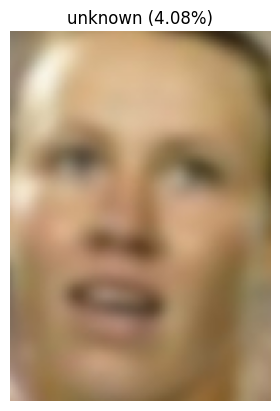

In [21]:
# ---------------------------
# TEST EXAMPLE
# ---------------------------
test_img_path = "/content/drive/MyDrive/Task_B/val/Alicia_Molik/distortion/Alicia_Molik_0001_blurred.jpg"
classify_image(test_img_path, clf, face_model)